## 注意力机制
- **随意线索**：随着意识的，主观想要着重考虑的
- **不随意线索**：不随意识，下意识的线索
- 之前讲过的**卷积， 池化，全连接**关注的都是不随意线索，通俗一点讲就是数据来了，我会把数据都扫一遍，每个地方都平等的扫一遍，而并没有体现出《我想要什么》
- 注意力机制可以理解为让模型自己学出来我想要什么

In [2]:
import torch
from d2l import torch as d2l
import matplotlib.pyplot as plt

In [3]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, 
                  figsize=(2.5,2.5), cmap='Reds'):
    # matrices [num_row, num_col, num_q, num_k]
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, 
                             sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == num_cols - 1:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)


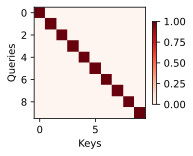

In [4]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

### NW核回归

In [5]:
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

- 根据以下式子生成数据集
$$y_i = 2\sin(x_i) + x_i^{0.8} + \epsilon,$$

In [16]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)


def f(x):
    return 2 * torch.sin(x) + x ** 0.8


y_train = f(x_train) + torch.normal(0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)
n_test

50

In [17]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

- 平均汇聚
$$f(x) = \frac{1}{n}\sum_{i=1}^n y_i,$$
- 相当于对于训练集中的y，每个y的权重都一样，进行算术平均即为预测值

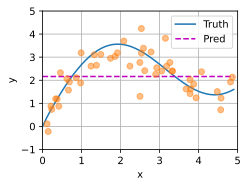

In [18]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

- **NW回归**：根据输入的未知，对训练集的$y_i$进行加权计算，看看哪个是离自己近的，更适合自己的
$$f(x) = \sum_{i=1}^n \frac{K(x - x_i)}{\sum_{j=1}^n K(x - x_j)} y_i,$$
- 在这个例子中，K是核函数，输入的位置就扮演了$query$这个角色，就相当于每个输入要根据自己的位置进行查询，训练集中的x就是$key$的角色，代表了这个数据点的属性，计算他们之间的权重，在NW回归中，距离远近与权重相关，算出来每个q与所有k的权重，然后进行加权平均
$$f(x) = \sum_{i=1}^n \alpha(x, x_i) y_i,$$
- 其中x是query， $(x_i, y_i)$是key-value pair
- 对于上个式子，我们引入高斯核：
$$K(u) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{u^2}{2}).$$
- 带入上式得到：
$$\begin{split}\begin{aligned} f(x) &=\sum_{i=1}^n \alpha(x, x_i) y_i\\ &= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}(x - x_i)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}(x - x_j)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}(x - x_i)^2\right) y_i. \end{aligned}\end{split}$$

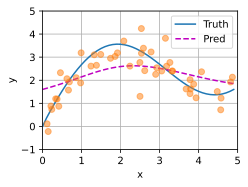

In [19]:
X_repeat = x_test.repeat_interleave(n_train).reshape(-1, n_train) # [n_test, n_train]
attention_weights = nn.functional.softmax(- (X_repeat - x_train) ** 2 / 2, dim=1) # [n_test, n_train]
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

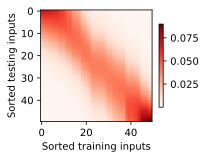

In [20]:
show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0), 
              xlabel='Sorted training inputs',
              ylabel='Sorted testing inputs')

### 可学习的NW回归
- 可学习，所以我们要学习模型的权重， 在上述公式的权重部分*一个可学习的参数，就可以获得一个可学习的模型
$$\begin{split}\begin{aligned}f(x) &= \sum_{i=1}^n \alpha(x, x_i) y_i \\&= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}((x - x_i)w)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}((x - x_j)w)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}((x - x_i)w)^2\right) y_i.\end{aligned}\end{split}$$

- 使用批量矩阵计算注意力数据

In [21]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

- 在注意力机制的背景中，我们可以使用小批量矩阵乘法来计算小批量数据中的**加权平均值**。就是注意力分数和value的加权值

In [23]:
weights = torch.ones(2, 10) * 0.1
values = torch.arange(20.0).reshape(2, 10)
# [2, 1,10] [2, 10, 1]
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))
# weights.unsqueeze(1).shape, values.unsqueeze(-1).shape

tensor([[[ 4.5000]],

        [[14.5000]]])

- NW回归带参数的版本

In [42]:
from torch.nn import functional as F
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))
    
    def forward(self, queries, keys, values):
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = F.softmax(
            -((queries - keys) * self.w) ** 2 / 2,
            dim=1
        )
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)    

- 模型训练
  - 在这里模型训练是使用训练集进行训练，每一个样本都会和除了他自己以外的样本计算注意力，然后来更新w

In [43]:
# [n_train, n_train]
X_tile = x_train.repeat((n_train, 1))
# [n_train, n_train]
Y_tile = y_train.repeat((n_train, 1))
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

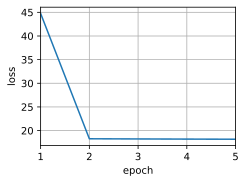

In [45]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, (l.sum().detach().numpy(),))

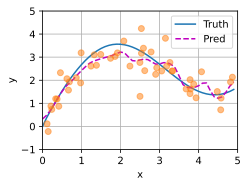

In [51]:
keys = x_train.repeat((n_test, 1))
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values)
plot_kernel_reg(y_hat.detach().numpy())

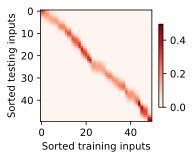

In [52]:
show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
              xlabel='Sorted training inputs',
               ylabel='Sorted testing inputs')